In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
x_transaction = pd.read_csv('../../kkbox-churn-prediction-challenge/train/X_train_transactions.csv')

In [3]:
x_transaction.shape

(24798, 35)

In [4]:
x_log = pd.read_csv('../../kkbox-churn-prediction-challenge/train/X_train_user_logs.csv')

In [5]:
x_log.shape

(24798, 24)

In [6]:
x_member = pd.read_csv('../../kkbox-churn-prediction-challenge/under_sample/X_train.csv')

In [7]:
x_member.shape

(24798, 6)

In [8]:
x_member.head(1)

,msno,city,bd,gender,registered_via,registration_init_time
0,iFmFHtGY2Luh1zwTlfNkht9RkvsVePqs16RHZby8eiQ=,22,36,female,9,20100316


In [9]:
# fill na for gender
x_member["gender"]=x_member["gender"].fillna("Unknown")

In [10]:
# registration_init_time
x_member.registration_init_time=pd.to_datetime(x_member.registration_init_time, format="%Y%m%d")
x_member['register_days'] = (pd.to_datetime("20170131", format="%Y%m%d")-x_member.registration_init_time).dt.days

In [11]:
x_member.head(1)
# for now, did not change bd just scale

,msno,city,bd,gender,registered_via,registration_init_time,register_days
0,iFmFHtGY2Luh1zwTlfNkht9RkvsVePqs16RHZby8eiQ=,22,36,female,9,2010-03-16,2513


In [12]:
data_frames=[x_member,x_log,x_transaction]
from functools import reduce
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['msno'],
                                            how='inner'), data_frames)

In [13]:
df_merged.head(1)

,msno,city,bd,gender,registered_via,registration_init_time,register_days,date_count,date_first,num_25_sum,...,length_sum,length_std,amtperday_mean,transaction_date_first,d_transaction_mean,d_transaction_std,d_expire_date_mean,d_expire_date_std,potential_churn_has_discount,membership_days
0,iFmFHtGY2Luh1zwTlfNkht9RkvsVePqs16RHZby8eiQ=,22,36,female,9,2010-03-16,2513,604,2015-01-01T00:00:00,2366,...,841,11.073767,5.281874,2015-01-06,29.035714,10.716834,29.892857,14.88061,False,867


### get interaction variables

In [14]:
# Count of days listening to music (log) / days of membership (transaction)
df_merged['listen_member_pct']=df_merged['date_count']/df_merged['membership_days']
df_merged.listen_member_pct = np.where(df_merged.listen_member_pct >1, 1,df_merged.listen_member_pct)
# because the log has more days record than the transaction (both before & after), make the >1 to 1

In [15]:
# First transaction (transaction) - registration date (member)
df_merged['register_member_sub'] = (pd.to_datetime(df_merged['transaction_date_first'], infer_datetime_format=True)-df_merged['registration_init_time']).dt.days

In [16]:
# Days of membership  (transaction) / dates of registration (member)
df_merged['member_register_pct']= df_merged['membership_days']/df_merged['register_days']
df_merged.member_register_pct = np.where(df_merged.member_register_pct >1, 1,df_merged.member_register_pct)
# because registration is to 0131, therefore, the estimate for this number all is larger, make the >1 to 1

In [17]:
df_merged.head(1)

,msno,city,bd,gender,registered_via,registration_init_time,register_days,date_count,date_first,num_25_sum,...,transaction_date_first,d_transaction_mean,d_transaction_std,d_expire_date_mean,d_expire_date_std,potential_churn_has_discount,membership_days,listen_member_pct,register_member_sub,member_register_pct
0,iFmFHtGY2Luh1zwTlfNkht9RkvsVePqs16RHZby8eiQ=,22,36,female,9,2010-03-16,2513,604,2015-01-01T00:00:00,2366,...,2015-01-06,29.035714,10.716834,29.892857,14.88061,False,867,0.696655,1757,0.345006


In [18]:
df_merged=df_merged.drop(['registration_init_time', 'date_first',"transaction_date_first"], axis=1)

In [19]:
df_merged.to_csv('../../kkbox-churn-prediction-challenge/train/X_train_combined.csv',index=False)

### Model

In [19]:
X_train = pd.read_csv('../../kkbox-churn-prediction-challenge/train/X_train_combined.csv')

In [20]:
X_train = X_train.sort_values('msno')

In [100]:
y = pd.read_csv('../../kkbox-churn-prediction-challenge/under_sample/y_train.csv', header=None).sort_values(0)
#y = y.drop([0],axis=1).values.ravel()

In [110]:
y.columns=['msno', 'is_churn']

### EDA

In [117]:
df_eda = pd.merge(X_train,y,on='msno',how='inner')
#[df_eda.register_days < 2000]

/Users/wangzhengye/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


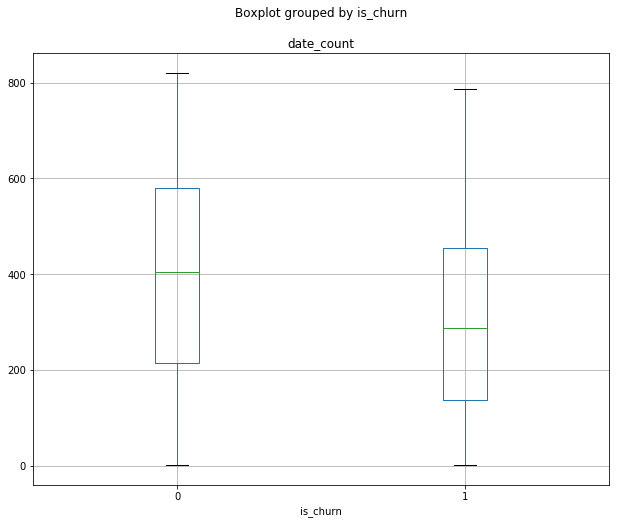

In [118]:
df_eda.boxplot(column='date_count',by='is_churn',figsize=(10,8))
plt.show()

In [135]:
table = df_eda.pivot_table(index='is_churn', columns='free_has_discount', aggfunc='size')
table.plot(kind='bar', stacked=True)

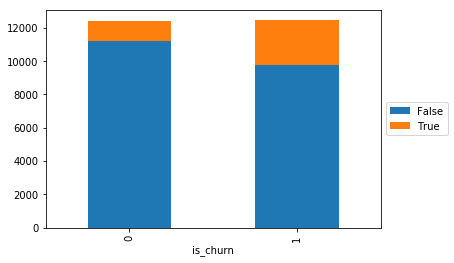

In [136]:
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

### Pipeline

In [21]:
cat_attribs=['city','gender','registered_via','payment_method_id_most_common','payment_plan_days_most_common',
             'plan_list_price_most_common','actual_amount_paid_most_common','is_auto_renew_change_or_not',
             'is_auto_renew_most_common','is_cancel_change_or_not', 'discount_amount_has_discount', 
             'free_has_discount','potential_churn_has_discount']
num_attribs = ['register_days','date_count','num_25_sum', 'num_25_mean', 'num_25_std','num_50_sum','num_50_mean',
               'num_50_std', 'num_75_sum', 'num_75_mean', 'num_75_std', 'num_985_sum','num_985_mean', 'num_985_std',
               'num_100_sum', 'num_100_mean','num_100_std', 'num_unq_sum', 'num_unq_mean', 'num_unq_std',
               'total_secs_sum', 'total_secs_mean', 'total_secs_std','payment_method_id_nunique','payment_plan_days_nunique','plan_list_price_nunique','plan_list_price_mean', 'plan_list_price_max_min_diff',
               'actual_amount_paid_nunique','actual_amount_paid_mean', 'actual_amount_paid_max_min_diff',
               'is_auto_renew_pcet_of_zero','is_cancel_mean','discount_amount_find_positive_pct',
               'discount_amount_mean', 'discount_amount_sum','free_mean', 'length_mean', 'length_sum', 'length_std', 'amtperday_mean','d_transaction_mean', 'd_transaction_std',
               'd_expire_date_mean', 'd_expire_date_std','membership_days', 'listen_member_pct',
               'register_member_sub', 'member_register_pct','bd']

In [22]:
len(num_attribs)

50

In [23]:
len(cat_attribs)

13

In [24]:
set(X_train.columns.get_values())-set(cat_attribs)-set(num_attribs)

{'msno'}

In [25]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import FeatureUnion, Pipeline

In [26]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X,y=None):
        return self
    def transform(self,X):
        return X[self.attribute_names].values

In [27]:
cat_pipeline = Pipeline([
    ('selector',DataFrameSelector(cat_attribs)),
    ('onehot',OneHotEncoder(drop="first",categories="auto"))])
num_pipeline = Pipeline([
    ('selector',DataFrameSelector(num_attribs)),
    ('std_scaler',StandardScaler())
])

In [28]:
full_pipeline = FeatureUnion(transformer_list=[
    ("cat_pipeline",cat_pipeline),
    ("num_pipeline",num_pipeline)
])

In [29]:
x_prepared = full_pipeline.fit_transform(X_train)

### Model

In [30]:
from sklearn.linear_model import LogisticRegression

In [31]:
y = pd.read_csv('../../kkbox-churn-prediction-challenge/under_sample/y_train.csv', header=None).sort_values(0)

In [32]:
(y[0]==X_train['msno']).unique()

array([ True])

In [33]:
y = y.drop([0],axis=1).values.ravel()

In [34]:
log = LogisticRegression(max_iter=1000)

In [35]:
log.fit(x_prepared,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
y_pred = log.predict(x_prepared)
from sklearn.metrics import accuracy_score,log_loss,confusion_matrix, plot_confusion_matrix,plot_roc_curve

In [37]:
accuracy_score(y,y_pred)

0.9122106621501734

In [38]:
class_names=["retained","churn"]

[[10803  1566]
 [  611 11818]]


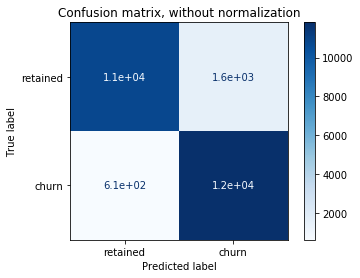

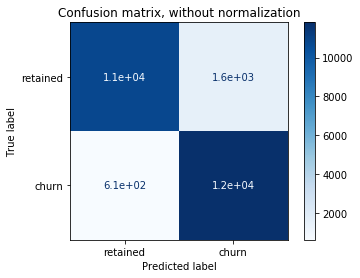

In [40]:
disp = plot_confusion_matrix(log, x_prepared, y,
                                 display_labels=class_names,
                                 cmap=plt.cm.Blues)
disp.ax_.set_title("Confusion matrix, without normalization")

print(disp.confusion_matrix)
plt.show()

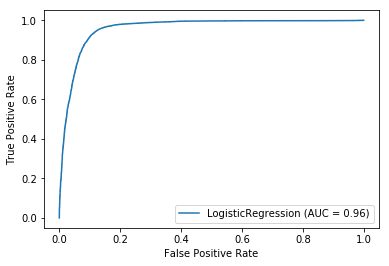

In [41]:
plot_roc_curve(log, x_prepared,y)
plt.show()

In [44]:
y_proba = log.predict_proba(x_prepared)

In [45]:
y_proba

array([[0.34805319, 0.65194681],
       [0.99310142, 0.00689858],
       [0.01709991, 0.98290009],
       ...,
       [0.03180937, 0.96819063],
       [0.99793691, 0.00206309],
       [0.09259849, 0.90740151]])

In [48]:
test = y_proba

In [49]:
test=np.where(test > (1-10^(-15)), (1-10^(-15)), test)
test=np.where(test > 10^(-15), test, 10^(-15))

In [50]:
log_loss(y,test) 

0.25927301920437007